# Austin Animal Shelter Classifier
## Alana Dillinger and Kristen Burgett
### CPSC 310
### May 9, 2019
### Final Project

## Introduction
For our project, we chose to use a data file from an adoption shelter in Austin, TX. The animals from the shelter were saved into a .csv file that we had to clean and then classify using a few different methods. We wanted to classify how long an incoming dog would spend at the shelter based on their breed, age, and a few other attributes. Being able to classify well how long an animal would stay at the shelter would be usful for the people running the shelters so the can work hard to get all the animals adopted and plan for their stay making sure they have everything they need to make the animals time in the shelter easier.

## Cleaning the data
To clean the data, we first had to remove all of the instances that were not dogs so cats, birds, etc. We then saved this data in a new file, dogs_data.csv. In order to classify the dogs and predict the time they would spend at the shelter, we had to remove quite a few attributes that were repeated or challenging to use. We kept most of the discretized and categorical data but removed the location they were found, their names, time they were taken in, time they were adopted, and any attributes that were repetative. We saved this file as clean_data.csv and it is the file we referred back to in order to get the data needed for classification

In [40]:
import copy
import utils

In [41]:
def preprocess():

    attr, table = utils.parse_csv("adoption_data.csv")

    # Preserve animal entries for dogs and classifying attribute entry 
    animal_index = attr.index('animal_type_intake')
    class_index = attr.index('time_bucket')
    table = [row for row in table if row[animal_index] == 'Dog' and row[class_index] != '']

    # Remove all duplicate entries 
    animal_ids = set()
    animal_id_index = attr.index('animal_id')
    for row in table:
        # Check for duplicates
        if row[animal_id_index] in animal_ids:
            table.remove(row)
        else: 
            print(row[animal_id_index])
            animal_ids.add(row[animal_id_index]) 
    dogs_data = copy.deepcopy(table)
    utils.write_csv('dogs_data.csv', attr, dogs_data)

    # Remove attributes not to be trained on from instances in the dataset 
    remove_attr = ['animal_id', 'name_intake', 'date_time_intake', 'found_location', 'intake_condition', 
                    'animal_type_intake', 'month_year_intake', 'intake_sex', 'breed_intake', 'color_intake', 
                    'name_outcome', 'date_time_outcome', 'month_year_outcome','outcome_subtype', 'outcome_sex', 
                    'outcome_age', 'gender_outcome', 'fixed_intake', 'fixed_changed', 'date_time_length']

    # Remove each attribute from all rows 
    for col in remove_attr: 
        index = attr.index(col)
        attr.pop(index)
        for row in table: 
            row.pop(index)    

    utils.write_csv('clean_data.csv', attr, table)
    


### How we used the Data

We only cleaned the data once and stored it in .csv files. "dogs_data.csv" was the data with just the cats, birds, etc removed so we could access the full instance for each dog with all of the attributes such as name, breed, color, etc that we may need to reference before removing all of the attributes that we would not need for cleaning.

The "clean_data.csv" is the file which we stored the data we would use to classify instances so instead of processing the data each time we ran our program we could just call it from the file. Wil working with the data, we needed to further clean it so we could work with it easily and discretized the age of the dogs so we could use that attribute for classification

In [42]:
def discretize_age(table, attr):
    '''
    '''
    age_index = attr.index('age')
    age_bucket_index = attr.index('age_bucket')
    age_bucket_domain = utils.get_attr_domains(table, attr, [age_bucket_index])
    age_bucket_domain = age_bucket_domain['age_bucket']
    
    # Bucket Keys
    years = sorted([y for y in age_bucket_domain if 'year' in y], reverse=True)
    months = sorted([m for m in age_bucket_domain if 'month' in m], reverse=True)
    weeks = sorted([w for w in age_bucket_domain if 'week' in w], reverse=True)
    days = weeks.pop(0)

    for row in table:
        # Days
        if 'day' in row[age_index]:
            row[age_index] = days 
        # Weeks
        if 'week' in row[age_index]:
            row[age_index] = weeks[0]
        # Months
        if 'month' in row[age_index]:
            val = row[age_index].split(' ')[0]
            for m in months:
                if val > m[0]:
                    row[age_index] = m
                    break
            row[age_index] = months[len(months) - 1]
        # Years
        if 'year' in row[age_index]:
            val = row[age_index].split(' ')[0]
            for y in years:
                if val > y[0]:
                    row[age_index] = y
                    break
            row[age_index] = years[len(years) - 1]
    
    return attr, table

attr, table = utils.parse_csv("clean_data.csv")
original_attr, original_table = utils.parse_csv('dogs_data.csv')
attr, table = discretize_age(table, attr)
utils.convert_data_to_numeric(table)

## Naive Bayes Classifier

The Naive Bayes Classifer did not work as well as we would have hoped, but it was nice to see how many of each classification appeared. After printing the confusion matrix it was easy to see that the vast majority of dogs fell into the 0-7 days confirming our other classifiers that we did not think were very accurate since most classifications were 0-7 days. The Naive Bayes Classifier only reaches an accuracy of around 0.5 and even after messing around with some of the variables, we were unable to make it any more notably accurate.

In [26]:
attr, table = utils.parse_csv("clean_data.csv")
attr_indexes = list(range(len(attr)))
class_index = attr_indexes.pop(len(attr) - 1)

In [32]:
from tabulate import tabulate

def naive_bayes_classifier(table, attr, attr_indexes, class_index): 
    '''
    Utilize Naive Bayes Classifier from utils.py file
    Train on cleaned data, to find accuracy of classifier. 
    '''  
     # Stratify data across 10 folds
    stratified_data = utils.stratify_data(table, class_index, 10)

    # Initialize data set up
    tp_tn = 0
    total = 0
    class_domains = utils.get_attr_domains(table, attr, [class_index])
    class_domains = class_domains[attr[class_index]]
    class_domains.sort(key = lambda x: x.split()[1])
    confusion_table= [[0 for _ in class_domains] for _ in class_domains]

    # Stratified folds
    for i in range(len(stratified_data)):
        train_set = []
        test_set = stratified_data.pop(i)
        total += len(test_set)
        for j in stratified_data:
            train_set.extend(j)

        # Calculate probabilities of training set
        classes, conditions, priors, posts = utils.prior_post_probabilities(train_set, attr, class_index, attr_indexes)

        # Iterate through test set
        for inst in test_set:
            # Classify predicted and actual classes
            pred_class = utils.naive_bayes(train_set, classes, conditions, attr, priors, posts, inst, class_index)
            actual_class = inst[class_index]
            if pred_class == actual_class:
                tp_tn += 1

            pred_label = class_domains.index(pred_class)
            actual_label = class_domains.index(actual_class)
            confusion_table[actual_label][pred_label] += 1

        # Return test set to stratified folds
        stratified_data.insert(i, test_set)

    # Calculate accuracy and Confusion Matrix
    acc = tp_tn / total
    confusion_matrix = utils.format_confusion_table(confusion_table, len(class_domains), class_domains)
    headers = class_domains
    headers.append("Total")
    headers.append("Recognition (%)")

    # OUTPUT
    print(class_domains)
    print("\n\nNAIVE BAYES")
    print("-" * 50)
    print("Accuracy = %f" % acc)
    print("Error Rate = %f" % (1 - acc))
    print()
    print(tabulate(confusion_matrix, headers, tablefmt='rst'))
    
def naive_bayes(data, classes, conditions, attributes, prior_probabilities, post_probabilities, test, class_index, apply_gaussian=False, g_index=None):
    '''
    Classify test instance based on prior and posterior probabilities of dataset 
    PARAMETERS: data = 2D list of dataset 
                classes = class labels 
                conditions = attributes data was trainined on 
                prior_probabilities = prior probabilities calculated 
                post_probabilities = post probabilities calculate
                test = test instance with list of attribute values 
                class_index = int representing index of attribute to classify test instance on 
                apply_gaussian = boolean determining if attribute should be treated as continous or categorical property 
                g_index = index of Gaussian attribute if exists 
    RETURNS: classified label of test instance 	
    '''
    class_probabilities = dict()

    for class_label in classes: 
        class_probabilities[class_label] = utils.prior_probabilities[class_label]
        if utils.apply_gaussian == True: 
            class_data = [row for row in data if row[class_index] == class_label]
            mean, stdev = utils.calculate_mean_std(get_column(class_data, g_index))
            class_probabilities[class_label] *= utils.gaussian(test[g_index], mean, stdev)
        for attr in conditions: 
            attr_label = test[attr]
            if (attributes[attr] + " = " + str(attr_label), attributes[class_index] + " = " + str(class_label)) in post_probabilities:
                class_probabilities[class_label] *= post_probabilities[attributes[attr] + " = " + str(attr_label), attributes[class_index] + " = " + str(class_label)]
            else:
                class_probabilities[class_label] *= 0

    k = list(class_probabilities.keys())
    v = list(class_probabilities.values())
    
    return k[v.index(max(v))]

In [33]:
naive_bayes_classifier(table, attr, attr_indexes, class_index)

['0-7 days', '6-12 months', '3-6 weeks', '1-3 weeks', '12 weeks - 6 months', '7-12 weeks', '1-2 years', '2+ years', 'Total', 'Recognition (%)']


NAIVE BAYES
--------------------------------------------------
Accuracy = 0.587164
Error Rate = 0.412836

===================  ==========  =============  ===========  ===========  =====================  ============  ===========  ==========  =======  =================
..                     0-7 days    6-12 months    3-6 weeks    1-3 weeks    12 weeks - 6 months    7-12 weeks    1-2 years    2+ years    Total    Recognition (%)
===================  ==========  =============  ===========  ===========  =====================  ============  ===========  ==========  =======  =================
0-7 days                  19118              0          117         1109                      3            50            0           0    20397          93.7295
6-12 months                 747              0            4          256                      1   

## Decision Tree Classifier

Using the decision tree classifer seemed like an easy step to take and would make it easy to create an ensemble classifier, but proved to be quite difficult. With the amount of instances it was had to build a large tree with a lot of rules to keep the accuracy high because often times there would be quite a few attributes that had no instances falling under it so often times it became case 3 and the tree had to generalize a large group of data with simple majority voting. Creating a decision tree was nice though because it allowed us to see rules that generalized the data set. We wanted to try using apriori to develop a list of rules to classify the data, but with 31,000+ instances, it took so long to run the algorithm that we were unable to use it and the rules from the decision tree are about as good as we could get and they are printed after creating a decision tree using entropy.

### Variables needed for the Decision Tree

To create the decision tree we needed a few variable such as the attribute domains, the indexes of the attribute we used, the index of the attribute we are classifying, and the values that the classification could be.

In [37]:
attr, table = utils.parse_csv("clean_data.csv")
attr_indexes = list(range(len(attr)))
class_index = attr_indexes.pop(len(attr) - 1)
attr_domains = utils.get_attr_domains(table, attr, attr_indexes)
class_values = utils.get_attr_domains(table, attr, [len(attr)-1])

In [38]:
def tdidt(instances, attr_indexes, attr_domains, class_index, header=None, chosen_attr=False): 
    '''
    Create a TDIDT classifier using entropy to select splitting attributes
    PARAMETERS: instances = 2D list of data set instances
                attr_indexes = list of attribute indexes to classify instances on
                attr_domains = list of dictionaries containing domains of attributes
                class_index = column index of classifier 
                header = list of names for columns/attributes of instances 
    RETURN: sub_tree = tdidt 
    '''
    # Pick attribute ("attribute selection")
    if not chosen_attr:
        attr_index = utils.select_attribute(instances, attr_indexes, class_index)
        attr_indexes.remove(attr_index)
    else:
        attr_index = attr_indexes.pop(0)
    
    # Parition data by attribute values 
    partition = utils.partition_instances(instances, attr_index, attr_domains.get(header[attr_index]))

    case3 = False
    sub_tree = ["Attribute", header[attr_index]]
    for partition_label in partition: 
        partition_label_instances = partition[partition_label]
        if len(partition_label_instances) == 0:
            # Case 3: No more instances to partition
            case3 = True
            break
        else:
            if utils.check_all_same_class(partition_label_instances, class_index):
                # Case 1: Partition has only class labels that are the same
                node = ["Leaves", [partition_label_instances[0][class_index], len(partition_label_instances), utils.count_partition(partition), round(len(partition_label_instances) / utils.count_partition(partition), 2)]]
            elif len(attr_indexes) == 0:
                # Case 2: No more attributes to partiton 
                label, _ = utils.compute_partition_stats(partition_label_instances, class_index)
                node = ["Leaves", [label, len(partition_label_instances), utils.count_partition(partition), round(len(partition_label_instances) / utils.count_partition(partition), 2)]]
            else: 
                new_attr_indexes = attr_indexes[:]
                node = tdidt(partition_label_instances, new_attr_indexes, attr_domains, class_index, header)
        
        value_list = ["Value", partition_label, node]
        sub_tree.append(value_list)

    # If case 3, attribute => leaf node
    if case3:
        label = utils.compute_partition_voting(partition, class_index)
        sub_tree = ["Leaves", [label, utils.count_partition(partition), utils.count_partition(partition), round(utils.count_partition(partition) / utils.count_partition(partition), 2)]]    
    
    return sub_tree 

def get_majority_vote(classifications):
    max_count = 0
    majority_classification = None
    classifications_set = set(classifications)
    for item in classifications_set:
        count = 0
        for classification in classifications:
            if classification == item:
                count += 1
        if count > max_count:
            majority_classification = item
    return majority_classification

In [66]:
tree = tdidt(table, attr_indexes, attr_domains, class_index, attr, False)
tdidt_rules(tree, attr, class_index, path=[])

IF outcome_type ==  THEN time_bucket = 1-3 weeks
IF outcome_type == Rto-Adopt THEN time_bucket = 0-7 days
IF outcome_type == Missing THEN time_bucket = 0-7 days
IF outcome_type == Adoption AND IF age_bucket == 4-6 years AND IF pitbull == 0 AND IF retriever == 0 THEN time_bucket = 0-7 days
IF outcome_type == Adoption AND IF age_bucket == 4-6 years AND IF pitbull == 0 AND IF retriever == 1 THEN time_bucket = 1-3 weeks
IF outcome_type == Adoption AND IF age_bucket == 4-6 years AND IF pitbull == 1 THEN time_bucket = 7-12 weeks
IF outcome_type == Adoption AND IF age_bucket == Less than 1 week AND IF boxer == 0 THEN time_bucket = 7-12 weeks
IF outcome_type == Adoption AND IF age_bucket == Less than 1 week AND IF boxer == 1 THEN time_bucket = 7-12 weeks
IF outcome_type == Adoption AND IF age_bucket == 1-6 weeks AND IF pitbull == 0 AND IF chihuahua == 0 THEN time_bucket = 3-6 weeks
IF outcome_type == Adoption AND IF age_bucket == 1-6 weeks AND IF pitbull == 0 AND IF chihuahua == 1 THEN time_bu

## Ensemble Classifier
### Random Forest Method

For our ensemble classifer, we used the random forest approach and built off of the decision tree classifier. To create the forest, we decided to select the best 7 of 10 trees created in order to keep computational costs at a minumum since it takes some time to go through all of that data, build multiple trees, test the trees on the validation set, and then use the forest to classify the instances in the training set. We were able to get our accuracy for the forest close to 0.6 which is better than the accuracy was for Naive Bayes. If we added more trees or used emsemble learning with different types of classifiers. We also changed the amounts of data we used for the training and test sets, but it did not make enough of a difference in the accuracies. Implementing the random forest again classifies almost every instance as 0-7 days but we have figured out that it is because this is the classification for a large majority of the data set.

In [42]:
import utils
import random

def forest_classifier(table, att_indexes, att_domains, class_index, header, class_values, n, m):
    '''
    Calls the functions to get a decision tree for the data and uses that decision
    tree and classifies a given instance. Returns the classification to main()
    '''
    test_set, remainder_set = random_test_set(table, header, 3, att_domains, class_values)
    forest = generate_forest(remainder_set, att_indexes, att_domains, class_index, header, [], n, m)
    correct_classifications = 0
    for instance in test_set:
        classifications = []
        for tree in forest:
            classifications.append(utils.classify_tdidt(tree, instance, header))
        classification = get_majority_vote(classifications)
        print(instance," classified as ", classification)
        if instance[len(instance) - 1] == classification:
            correct_classifications += 1
        
    print("Forest Accuracy: ", correct_classifications / len(test_set))

    
def random_test_set(table, header, k, att_domains, class_values):
    '''
    Build random test and training sets. 
    The training set is 2/3 of the data
    and the test set is 1/3 of the data
    '''
    random_table = table
    random.shuffle(random_table)
    training_set = []
    test_set = []
    for i in range(2 * len(table) // k):
        training_set.append(table[i])
    for i in range(2 * len(table) // k, len(table)- 1):
        test_set.append(table[i])

    return test_set, training_set
    
def bootstrap(remainder_set):
    training_set = []
    validation_set = []
    for i in range(2 * len(remainder_set) // 3):
        random_index = random.randint(0, len(remainder_set)-1)
        training_set.append(remainder_set[random_index])
    for i in range(len(remainder_set) // 3):
        random_index = random.randint(0, len(remainder_set)-1)
        validation_set.append(remainder_set[random_index])
    return training_set, validation_set
    
def generate_forest(remainder_set, attr_indexes, attr_domains, class_index, header, tree, n, m):
    forest = []
    best_trees = []
    for index in range(n):
        training_set, validation_set = bootstrap(remainder_set)
        tree = tdidt(training_set, attr_indexes, attr_domains, class_index, header, False)
        forest.append(tree)

    for i in range(m):
        best_trees.append(forest)

    for i in range(m, len(forest)):
        for j in range(len(best_trees)):
            if find_accuracy(best_trees[j], validation_set, header) < find_accuracy(forest[i], validation_set, header):
                best_trees[j] = forest[i]
                break
    return forest

def find_accuracy(tree, validation_set, header):
    correct_classifications = 0
    for instance in validation_set:
        classification = utils.classify_tdidt(tree, instance, header)
        if classification == instance[len(instance)-1]:
            correct_classifications += 1
    return correct_classifications / len(validation_set)



In [44]:
attr_indexes = list(range(len(attr)))
class_index = attr_indexes.pop(len(attr) - 1)
attr_domains = utils.get_attr_domains(table, attr, attr_indexes)
class_values = utils.get_attr_domains(table, attr, [len(attr)-1])

forest_classifier(table, attr_indexes, attr_domains, class_index, attr, class_values.get("time_bucket"), 10, 7)

['Owner Surrender', '11 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2+ years']  classified as  0-7 days
['Owner Surrender', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '7 years', 'Adoption', 'Female', 'Spayed', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '2 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-2 years']  classified as  0-7 days
['Stray', '1 month', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '3 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  1-3 weeks
['Public Assist', '1 month', 'Ado

['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '1 year', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0-7 days']  classified as  3-6 weeks
['Owner Surrender', '4 years', 'Adoption', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '1 year', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Public Assist', '5 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '6-12 months']  classified as  1-3 weeks
['Public Assist', '5 years', 'Return to Owner', 'Female', 'Intact', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  1-3 weeks
['Public Assist', '3 ye

['Owner Surrender', '2 months', 'Return to Owner', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '1 year', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '11 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Euthanasia', 'Female', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '2 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  1-3 weeks
['Stray', '1 year', 'Adopti

['Owner Surrender', '3 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Owner Surrender', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '4 years', 'Return to Owner', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '12 weeks - 6 months']  classified as  1-3 weeks
['Owner Surrender', '2 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '3-6 weeks']  classified as  1-3 weeks
['Stray', '1 year', 'Adop

['Stray', '11 years', 'Euthanasia', 'Female', 'Intact', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '2 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '7-12 weeks']  classified as  0-7 days
['Owner Surrender', '4 years', 'Transfer', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '3-6 weeks']  classified as  0-7 days
['Owner Surrender', '6 months', 'Transfer', 'Female', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '3-6 weeks']  classified as  1-3 weeks
['Stray', '1 year', 'Return to Owner', 'Male

['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '6-12 months']  classified as  1-3 weeks
['Stray', '9 years', 'Adoption', 'Female', 'Spayed', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '12 weeks - 6 months']  classified as  1-3 weeks
['Stray', '10 months', 'Return to Owner', 'Male', 'Neutered', '7-12 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '7-12 weeks']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '7-12 weeks']  classified as  1-3 weeks
['Stray', '13 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Public Assist', '1 year', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Public Assist', '8 years',

['Stray', '6 years', 'Adoption', 'Male', 'Intact', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2+ years']  classified as  0-7 days
['Owner Surrender', '2 years', 'Euthanasia', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '5 years', 'Transfer', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 months', 'Transfer', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '12 years', 'Transfer', 'Female', 'Intact', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0

['Stray', '7 years', 'Adoption', 'Male', 'Neutered', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '12 weeks - 6 months']  classified as  1-3 weeks
['Stray', '11 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '1 year', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-2 years']  classified as  0-7 days
['Stray', '7 years', 'Return to Owner', 'Male', 'Neutered', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '8 months', 'Adoption', 'Female', 'Spayed', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '3 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '9 years', 'Re

['Owner Surrender', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '2 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '12 weeks - 6 months']  classified as  1-3 weeks
['Stray', '1 year', 'Transfer', '', 'Unknown', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '6 years', 'Adoption', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '12 weeks - 6 months']  classified as  1-3 weeks
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '8 years', 'Return to Owner', 'Female', 'Spayed', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Adoption', 'Male

['Stray', '2 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '8 months', 'Adoption', 'Male', 'Neutered', '7-12 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '3-6 weeks']  classified as  0-7 days
['Stray', '2 months', 'Transfer', 'Female', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '11 months', 'Return to Owner', 'Female', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Male', 'Intact', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Euthanasia Request', '11 years', 'Euthanasia', 'Male', 'Ne

['Owner Surrender', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '8 years', 'Return to Owner', 'Female', 'Spayed', '7+ years', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '5 months', 'Transfer', 'Male', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '10 years', 'Transfer', 'Male', 'Neutered', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '4 years', 'Adoption', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '1 year', 'Adoption', 'Female', 'Sp

['Stray', '1 year', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '7-12 weeks']  classified as  1-3 weeks
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '12 weeks - 6 months']  classified as  1-3 weeks
['Public Assist', '5 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Owner Surrender', '7 years', 'Euthanasia', 'Male', 'Neutered', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '3-6 weeks']  classified as  1-3 weeks
['Stray', '4 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', '

['Owner Surrender', '2 years', 'Euthanasia', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '9 years', 'Adoption', 'Female', 'Spayed', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '6-12 months']  classified as  1-3 weeks
['Stray', '2 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  0-7 days
['Stray', '1 year', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '6-12 months']  classified as  0-7 days
['Owner Surrender', '5 years', 'Transfer', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '1 month', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Male', 'N

['Public Assist', '3 years', 'Return to Owner', 'Male', 'Intact', '1-3 years', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '2 years', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '4 years', 'Return to Owner', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '2 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '3-6 weeks']  classified as  1-3 weeks
['Stray', '5 years', 'Adoption', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '4 years', 'Transfer', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  0-7 days
['Stray', '5 years', 'Adoption', 'Male', 'Neuter

['Stray', '1 year', 'Adoption', 'Male', 'Intact', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '6-12 months']  classified as  1-3 weeks
['Owner Surrender', '1 year', 'Transfer', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Owner Surrender', '2 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '6-12 months']  classified as  0-7 days
['Stray', '1 month', 'Transfer', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Female', 'Spaye

['Stray', '2 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Female', 'Intact', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  0-7 days
['Stray', '3 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '5 months', 'Return to Owner', 'Female', 'Spayed', '1-6 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '6-12 months']  classified as  0-7 days
['Stray', '9 months', 'Adoption', 'Female', 'Spayed', '7-12 months', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '4 months', 'Transfer', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Owner Surrender', '6 months', 'Adoption', 'Female', 'Spa

['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '2 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '2 years', 'Transfer', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  3-6 weeks
['Stray', '3 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-2 years']  classified as  1-3 weeks
['Stray', '4 years', 'Return to Owner', 'Male', 'Neutered', '4-6 y

['Stray', '2 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '6 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-2 years']  classified as  0-7 days
['Stray', '5 years', 'Return to Owner', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '10 months', 'Adoption', 'Female', 'Spayed', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '4 years', 'Transfer', 'Male', 'Intact', '4-6 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '6 days', 'Transfer', '', 'Unknown', 'Less than 1 week', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  7-12 weeks
['Stray', '5 years', 'Adoption', 'Female', '

['Stray', '1 year', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '2 months', 'Transfer', 'Female', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '5 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '1 year', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '6-12 months']  classified as  0-7 days
['Public Assist', '8 months', 'Return to Owner', 'Male', 'Neutered', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '9 months', 'Adoptio

['Stray', '1 year', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '3-6 weeks']  classified as  0-7 days
['Public Assist', '6 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '2 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Male', 'Neu

['Owner Surrender', '11 months', 'Euthanasia', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '5 years', 'Adoption', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '4 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '1 year', 'Return to Owner', 'Female', 'Intact', '

['Stray', '1 year', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '8 years', 'Adoption', 'Female', 'Spayed', '7+ years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '15 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Return to Owner', 'Male', 'Intact', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 month', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Male', 'Intact', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '2 years', 'Transfer', 'Male', 'Neutered',

['Stray', '3 months', 'Transfer', 'Male', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '8 months', 'Adoption', 'Male', 'Neutered', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Owner Surrender', '10 months', 'Adoption', 'Female', 'Spayed', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 month', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '3 months', 'Transfer', 'Female', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '8 months', 'Adoption', 'Female', 'Spayed', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '12 weeks - 6 months']  classified as  1-3 weeks
['Stray', '10 years', 'Ret

['Stray', '1 month', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '7-12 weeks']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  0-7 days
['Stray', '3 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '12 weeks - 6 months']  classified as  1-3 weeks
['Stray', '2 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '7-12 weeks']  classified as  1-3 weeks
['Stray', '3 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '1 month', 'Return to Owner', 'Female', 'Spayed

['Stray', '11 years', 'Transfer', 'Male', 'Intact', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Public Assist', '9 years', 'Return to Owner', 'Male', 'Neutered', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  1-3 weeks
['Public Assist', '2 years', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '7 years', 'Transfer', 'Female', 'Intact', '7+ years', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '2 months', 'Transfer', 'Male', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Public Assist', '1 weeks', 'Return to Owner', 'Male', 'Intact', '1-6 weeks', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  1-3 weeks
['Stray', '1 year', 'Adoption', 

['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '5 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Owner Surrender', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '7-12 weeks']  classified as  1-3 weeks
['Stray', '2 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '2 years', 'Return to Owner', 'Mal

['Stray', '3 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0-7 days']  classified as  3-6 weeks
['Public Assist', '8 years', 'Return to Owner', 'Male', 'Neutered', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Owner Surrender', '10 months', 'Adoption', 'Male', 'Neutered', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Owner Surrender', '4 years', 'Adoption', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '7 months', 'Adoption', 'Female', 'Spayed', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption'

['Owner Surrender', '2 months', 'Transfer', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '5 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '6 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 month', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '3-6 weeks']  classified as  0-7 days
['Stray', '6 months', 'Return to Owner', 'Male', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '10 months', 'Adoption', 'Male', 'Neutered', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '10 months', 'Adoption', 'Female', 'S

['Public Assist', '6 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Public Assist', '2 years', 'Return to Owner', 'Female', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  1-3 weeks
['Stray', '1 year', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Owner Surrender', '3 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '3-6 weeks']  classified as  0-7 days
['Owner Surrender', '11 m

['Owner Surrender', '3 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '3 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 month', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '4 weeks', 'Transfer', 'Male', 'Intact', '1-6 weeks', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '9 months', 'Adoption', 'Male', 'Neu

['Public Assist', '2 years', 'Return to Owner', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '9 months', 'Transfer', 'Female', 'Intact', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Owner Surrender', '1 year', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Euthanasia Request', '2 years', 'Euthanasia', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 month', 'Adoption', 'Female', 'Spayed', '1-6 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Public Assist', '4 years', 'Return to Owner', 'Female', 'Intact', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  1-3 weeks
['Stray', '5 mon

['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '5 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Owner Surrender', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '8 years', 'Return to Owner', 'Female', 'Spayed', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '6-12 months']  classified as  0-7 days
['Stray', '2 months', 'Transfer', 'Female', 'Intact', '1-6 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '5 years', 'Return to Owner', 'Male', 'Neutered

['Stray', '2 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '5 years', 'Transfer', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '2 years', 'Transfer', 'Female', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Owner Surrender', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '2 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '7-12 weeks']  classified as  1-3 weeks
['Stray', '1 year', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Male', 'Neutered'

['Stray', '1 month', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '14 years', 'Transfer', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '5 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Owner Surrender', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '12 years', 'Euthanasia', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '8 months', 'Return to Owner', 'Male', 'Neutered', '7-12 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '4 years', 'Transf

['Euthanasia Request', '10 years', 'Euthanasia', 'Male', 'Intact', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Female', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '6-12 months']  classified as  0-7 days
['Public Assist', '6 months', 'Return to Owner', 'Male', 'Intact', '1-6 months', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '7-12 weeks']  classified as  1-3 weeks
['Stray', '1 month', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 months', 'Transfer', 'Male', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Return to Owner', 'Female', 

['Stray', '11 months', 'Return to Owner', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '2 years', 'Return to Owner', 'Female', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  1-3 weeks
['Stray', '5 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '3-6 weeks']  classified as  0-7 days
['Stray', '4 months', 'Transfer', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '2 years', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '5 years', 'Adoption', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '8 months', 'Adoption', 'Male

['Stray', '2 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '9 months', 'Adoption', 'Female', 'Spayed', '7-12 months', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  1-3 weeks
['Public Assist', '1 year', 'Euthanasia', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  1-3 weeks
['Stray', '5 years', 'Transfer', 'Female', 'Spayed', '4-6 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '2 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '3-6 weeks']  classified as  1-3 weeks
['Stray', '4 years', 'Return to Owner', 'Male'

['Owner Surrender', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Public Assist', '7 years', 'Return to Owner', 'Female', 'Spayed', '7+ years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Owner Surrender', '11 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '6 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '4 weeks', 'Adoption', 'Female', 'Spayed', '1-6 weeks', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '6-12 months']  classified as  3-6 weeks
['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '3 years', 'Adopt

['Owner Surrender', '2 years', 'Transfer', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '5 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Public Assist', '8 months', 'Adoption', 'Male', 'Neutered', '7-12 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '7-12 weeks']  classified as  1-3 weeks
['Stray', '1 month', 'Adoption', 'Male', 'Neutered', '1-6 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '9 months', 'Adoption', 'Female', 'Spayed', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '7-12 weeks']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', '

['Stray', '3 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '12 weeks - 6 months']  classified as  0-7 days
['Stray', '1 year', 'Return to Owner', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '2 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '5 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '4 years', 'Adoption', 'Female', 'Spayed', '4-6 years', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', '

['Owner Surrender', '6 years', 'Transfer', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '4 years', 'Return to Owner', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Public Assist', '5 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '2 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Owner Surrender', '5 months', 'Adoption

['Owner Surrender', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Owner Surrender', '2 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  3-6 weeks
['Stray', '2 years', 'Return to Owner', 'Male', 'Intact', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '3-6 weeks']  classified as  1-3 weeks
['Stray', '1 month', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '6-12 months']  classified as  0-7 days
['Public Assist', '2 years', 'Return to Owner', 'Male', 'Intact', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '3 years', 'Return t

['Stray', '1 month', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '3-6 weeks']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '3-6 weeks']  classified as  1-3 weeks
['Stray', '4 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '3 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  1-3 weeks
['Owner Surrender', '5 months', 'Return to Owner', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '7 months', 'Transfer', 'Male', 

['Stray', '2 months', 'Return to Owner', 'Male', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '4 years', 'Adoption', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Owner Surrender', '5 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '12 weeks - 6 months']  classified as  0-7 days
['Public Assist', '7 years', 'Return to Owne

['Public Assist', '5 years', 'Euthanasia', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Public Assist', '7 years', 'Return to Owner', 'Female', 'Spayed', '7+ years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '7-12 weeks']  classified as  1-3 weeks
['Stray', '9 years', 'Return to Owner', 'Female', 'Spayed', '7+ years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Male', 

['Stray', '5 years', 'Transfer', 'Female', 'Intact', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '4 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '9 years', 'Adoption', 'Male', 'Neutered', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '12 weeks - 6 months']  classified as  1-3 weeks
['Stray', '2 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Transfer', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '1 month', 'Adoption', 'Female', 'Spayed', '1-6 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '7 years', 'Euthanasia', '

['Stray', '1 month', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Transfer', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '3-6 weeks']  classified as  1-3 weeks
['Stray', '1 month', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '1 year', 'Return to Owner', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '4 years', 'Adoption', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '5 months', 'Adoption', 'Male', 'Neutered', '1-6 mont

['Stray', '15 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 months', 'Transfer', 'Male', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 weeks', 'Transfer', 'Male', 'Intact', '1-6 weeks', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Owner Surrender', '4 years', 'Transfer', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '16 years', 'Return to Owner', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '1 month', 'Adoption', 'Mal

['Stray', '3 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Public Assist', '9 months', 'Return to Owner', 'Male', 'Intact', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  1-3 weeks
['Stray', '4 years', 'Adoption', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '6-12 months']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '3-6 weeks']  classified as  1-3 weeks
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  1-3 weeks
['Owner Surrender', '2 years', 'Euthanasia', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '1 day', 'Died', 'Female', 'Intact',

['Stray', '9 months', 'Adoption', 'Male', 'Neutered', '7-12 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  1-3 weeks
['Stray', '9 months', 'Adoption', 'Female', 'Spayed', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '3 years', 'Euthanasia', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '8 years', 'Return to Owner', 'Female', 'Intact', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Public Assist', '4 years', 'Return to Owner', 'Male', 'Intact', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  1-3 weeks
['Stray', '8 years', 'Return to Owner', 'Fem

['Stray', '1 month', 'Transfer', 'Female', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 months', 'Died', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '9 months', 'Transfer', 'Male', 'Intact', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '1 year', 'Return to Owner', 'Male', 'Neutered', 

['Stray', '4 years', 'Missing', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Public Assist', '2 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '6 years', 'Adoption', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Male', 'Intact', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '5 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Female', 'Spayed', '1-3 years'

['Stray', '2 years', 'Return to Owner', 'Female', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '5 years', 'Adoption', 'Male', 'Intact', '4-6 years', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '2 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '3-6 weeks']  classified as  0-7 days
['Stray', '11 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Transfer', 'Female', 'Intact', '1-3 

['Stray', '2 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Public Assist', '9 years', 'Return to Owner', 'Female', 'Spayed', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '9 years', 'Return to Owner', 'Male', 'Neutered', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '5 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '4 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Public Assist', '9 m

['Stray', '4 months', 'Transfer', 'Male', 'Intact', '1-6 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '3 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Owner Surrender', '3 years', 'Transfer', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Euthanasia Request', '6 years', 'Euthanasia', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 month', 'Transfer', 'Male', 'Intact

['Stray', '9 months', 'Adoption', 'Male', 'Neutered', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '7-12 weeks']  classified as  1-3 weeks
['Stray', '5 months', 'Return to Owner', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '3-6 weeks']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Female', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '2 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '9 months', 'Adoption', 'Female', 'Spayed', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '4 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Male', 'Neutered', 

['Stray', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 months', 'Return to Owner', 'Female', 'Intact', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Owner Surrender', '2 years', 'Transfer', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 months', 'Transfer', 'Female', 'Intact', '1-6 months', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '1 year', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '1 year', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Male', 'I

['Stray', '1 year', 'Transfer', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Owner Surrender', '2 years', 'Euthanasia', 'Female', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  0-7 days
['Stray', '4 years', 'Adoption', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '6-12 months']  classified as  0-7 days
['Stray', '1 month', 'Return to Owner', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Owner Surrender', '6 years', 'Adoption', 'Male', 'Neuter

['Stray', '2 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '4 years', 'Transfer', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '2+ years']  classified as  1-3 weeks
['Stray', '6 years', 'Return to Owner', 'Male', 'Intact', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '1 year', 'Transfer', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '2 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 month', 'Adoption', 'Male', 'Neutered', '1-6 

['Stray', '9 years', 'Return to Owner', 'Male', 'Neutered', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1-3 weeks']  classified as  0-7 days
['Owner Surrender', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '4 years', 'Return to Owner', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  1-3 weeks
['Stray', '1 year', 'Adoption', 'Male', 'Intact', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '13 years', 'Adoption', 'Female', 'Inta

['Stray', '2 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '3-6 weeks']  classified as  1-2 years
['Stray', '4 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '5 months', 'Adoption', 'Male', 'Intact', '1-6 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Male', 'Neutered', '1-3 years',

['Stray', '4 years', 'Return to Owner', 'Female', 'Spayed', '4-6 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '3-6 weeks']  classified as  1-3 weeks
['Owner Surrender', '2 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0-7 days']  classified as  0-7 days
['Public Assist', '2 years', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  1-3 weeks
['Stray', '2 years', 'Adoption', 'Male', 'Ne

['Public Assist', '3 years', 'Return to Owner', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '10 years', 'Return to Owner', 'Male', 'Neutered', '7+ years', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '6 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '2 years', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '10 months', 'Adoption', 'Male', 'Neutered', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  1-3 weeks
['Stray', '2 weeks', 'Adoption', 'Female', 'Spayed', '1-6 weeks', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '7-12 weeks']  classified as  3-6 weeks
['Stray', '5 years', 'Euthanasia

['Stray', '4 years', 'Adoption', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '2 years', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '7 years', 'Return to Owner', 'Female', 'Spayed', '7+ years', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '5 years', 'Adoption', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1-3 weeks']  classified as  1-3 weeks
['Stray', '8 months', 'Adoption', 'Male', 'Neutered', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '7-12 weeks']  classified as  0-7 days
['Stray', '3 years', 'Return to Owner', 'Female', 'Spayed', '1-3 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years

['Stray', '1 month', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '6 years', 'Adoption', 'Female', 'Spayed', '4-6 years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '12 weeks - 6 months']  classified as  1-3 weeks
['Owner Surrender', '2 days', 'Adoption', 'Female', 'Spayed', 'Less than 1 week', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '7-12 weeks']  classified as  7-12 weeks
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Transfer', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '8 months', 'Adoption', 'Male', 'Neutered', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '3-6 weeks']  classified as  1-3 weeks
['Owner Surrender', '10 years', 'Adopt

['Stray', '6 years', 'Return to Owner', 'Male', 'Neutered', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 month', 'Transfer', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Owner Surrender', '2 years', 'Transfer', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '2 years', 'Return to Owner', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '2 years', 'Transfer', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '3 years', 'Transfer', 'Female', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '1 year', 'Return to Owner', 'Mal

['Stray', '7 months', 'Return to Owner', 'Male', 'Neutered', '7-12 months', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '12 weeks - 6 months']  classified as  0-7 days
['Public Assist', '2 years', 'Return to Owner', 'Female', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Stray', '5 months', 'Adoption', 'Female', 'Spayed', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '4 months', 'Adoption', 'Male', 'Neutered', '1-6 months', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '6 years', 'Transfer', 'Female', 'Intact', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Stray', '1 year', 'Adoption', 'Female', 'Spayed', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '12 weeks - 6 months']  classified as  0-7 days
['Stray', '4 months', 'Adopti

['Owner Surrender', '5 years', 'Adoption', 'Female', 'Spayed', '4-6 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '12 weeks - 6 months']  classified as  1-3 weeks
['Stray', '8 years', 'Return to Owner', 'Male', 'Neutered', '7+ years', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
['Public Assist', '7 years', 'Return to Owner', 'Male', 'Neutered', '7+ years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  1-3 weeks
['Owner Surrender', '8 months', 'Died', 'Male', 'Intact', '7-12 months', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0-7 days']  classified as  0-7 days
['Stray', '5 days', 'Adoption', 'Female', 'Spayed', 'Less than 1 week', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '7-12 weeks']  classified as  7-12 weeks
['Stray', '1 year', 'Adoption', 'Male', 'Neutered', '1-3 years', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1-3 weeks']  classified as  0-7 days
['Stray', '1 month', 

['Stray', '1 year', 'Transfer', 'Male', 'Intact', '1-3 years', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0-7 days']  classified as  0-7 days
Forest Accuracy:  0.5764246552583485


## K-Means Clustering Classifier

To use k-means clustering, we had to discretize the data and make some of our categorical attributes continuous. Since we have never written a k-means clustering algorithm before we have included all of the functions we used here.

In [12]:
def discretize_data(table, attr, attr_indexes, attr_domains):
    '''
    Convert categorical data into continuous data based on values
    attr_domains
    PARAMETERS: table = 2D list of data instances
                attr = list of attributes
                attr_indexes = indexes of attributes to be discretized
                attr_domains = dictionary of domain values for attributes
    RETURNS: table with new discretized attribute values
    '''
    for a in attr:
        attr_index = attr.index(a)
        attr_col = utils.get_column(table, attr_index)
        if all(isinstance(n, int) for n in attr_col) == False:
            attr_domain = attr_domains[a]
            sorted(attr_domain)
            for row in table:
                if row[attr_index] != '':
                    row[attr_index] = attr_domain.index(row[attr_index])
                else:
                    del row
            attr_domains[a] = attr_domain
            
def get_inital_centroids(data, k):
    '''
    Return initial k inital centroids
    PARAMETERS: data = 2D list of instances 
                k = k-value
    RETURNS: centroids = list of centorid instances 
    '''
    centroids = []
    for _ in range(k):
        centroids.append(data[random.randrange(len(data))])

    return centroids

def compute_centroids(clusters):
    '''
    Calculate centroid for each cluster given instances in each cluster
    PARAMETERS: clusters = 2D list of instances in each cluster
    RETURNS: centroids = new calculated centroid value for each cluster
    '''
    centroids = []
    for cluster in clusters:
        centroid = []
        for attr in range(len(cluster[0])):
            attr_col = utils.get_column(cluster, attr)
            centroid.append(sum(attr_col)/len(attr_col))

        centroids.append(centroid)

    return centroids

def check_clusters_moved(old_centroids, centroids):
    '''
    Compare old_centorids and centroids at i to see if they moved location
    PARAMETERS: old_centroids = list of old centroid values
                centroids = list of new calculated centroid values
    RETURNS: True if centroid position moves, otherwise Flase
    '''
    for i in range(len(centroids)):
        if not old_centroids[i] == centroids[i]:
            return True
    return False

def cluster_quality(centroids, clusters):
    '''
    Utlize Total Sum of Squares (TSS) as objective function
    to measure cluster quality
    PARAMETERS: centroids = centroid value of all clusters
                clusters = 2D list of instances in each cluster
    RETURNS: TSS value for clusters
    '''
    TSS = 0
    for i in range(len(centroids)):
        cluster_qual = 0
        for inst in clusters[i]:
            for attr in range(len(centroids[i])):
                cluster_qual += (centroids[i][attr] - inst[attr]) ** 2
        TSS += cluster_qual

    return TSS

In [17]:
def clustering(table, attr, attr_indexes, attr_domains):
    '''
    Implement unsupervised classifier: k-Means Clustering 
    '''
    # Change categorical data into continuous data
    utils.discretize_data(table, attr, attr_indexes, attr_domains)

    # Find best k-value
    best_k = 0
    best_clusters = []
    best_centroids = []
    k_clusters = []
    cluster_scores = []
    for i in range(2, len(attr)):
        k_clusters.append(i)
        cluster_quality, clusters, centroids = k_means_clustering(table, attr_indexes, i)
        cluster_scores.append(cluster_quality)
        
        if cluster_quality <= min(cluster_scores):
            best_k = i
            best_clusters = clusters
            best_centroids = centroids
    
    best_k = k_clusters[cluster_scores.index(min(cluster_scores))]
    
    # Show k-value Cluster Qualities to determine best k
    plt.figure()
    plt.title("Best k-value")
    plt.xlabel("Number of clusters k")
    plt.ylabel("TSS Value")
    plt.plot(k_clusters, cluster_scores)
    plt.show()

    # Show most common values for each attribute in a cluster
    print("=" * 50)
    print("MOST COMMON ATTRIBUTE VALUES BASED ON CLUSTER")
    print("=" * 50)
    for cluster in best_clusters:
        print("-" * 50)
        print("Cluster ", best_clusters.index(cluster))
        print("-" * 50)
        for i in range(len(attr)): 
            attr_col = utils.get_frequencies(cluster, i)
            k = list(attr_col.keys())
            v = list(attr_col.values())
            val = k[v.index(max(v))]
            attr_domain = attr_domains[attr[i]]
            print("%s : %s" % (attr[i], attr_domain[val]))
    
def k_means_clustering(data, attr_indexes, k):
    '''
    Perrform k-Means Clustering Classifier
    PARAMETERS: data = 2D list of instances
                attr_indexs = list of indexes to create clusters 
                k = k-value 
    RETURNS: cluster_quality = TSS value of cluster quality
             clusters = list of clustered instances
             centroids = list of centroid values for each cluster
    '''
    # Select k instances for initial centroids
    centroids = get_inital_centroids(data, k)
    clusters = [[c] for c in centroids]

    moved = True
    i = 0
    while moved:
        # Assign each instance to it's nearest cluster
        inst = data[i]
        distances = []
        for c in centroids:
            dist = utils.compute_distance(inst, c, attr_indexes)
            distances.append(dist)

        cluster_index = distances.index(min(distances))
        clusters[cluster_index].append(inst)

        # Recalculate centroid
        old_centroids = centroids
        centroids = compute_centroids(clusters)

        # Check if centroids moved to continue
        moved = check_clusters_moved(old_centroids, centroids)
        if moved:
            i += 1
            if i >= len(data):
                moved = False

    # Output Cluster Quality of Classifier, Clusters and Centroids
    return cluster_quality(centroids, clusters), clusters, centroids

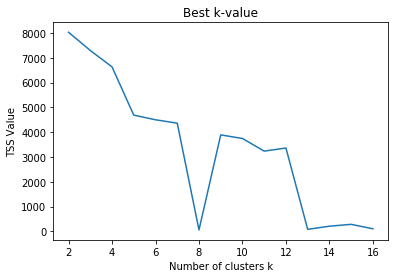

MOST COMMON ATTRIBUTE VALUES BASED ON CLUSTER
--------------------------------------------------
Cluster  0
--------------------------------------------------
intake_type : Stray
intake_condition : Normal
outcome_type : Adoption
gender_intake : Female
fixed_outcome : Spayed
age_bucket : 4-6 years
retriever : 0
shepherd : 0
beagle : 0
terrier : 0
boxer : 0
poodle : 0
rottweiler : 0
dachshund : 0
chihuahua : 1
pitbull : 0
time_bucket : 1-3 weeks
--------------------------------------------------
Cluster  1
--------------------------------------------------
intake_type : Stray
intake_condition : Normal
outcome_type : Return to Owner
gender_intake : Male
fixed_outcome : Neutered
age_bucket : 1-6 months
retriever : 0
shepherd : 0
beagle : 0
terrier : 0
boxer : 0
poodle : 0
rottweiler : 0
dachshund : 0
chihuahua : 0
pitbull : 0
time_bucket : 0-7 days
--------------------------------------------------
Cluster  2
--------------------------------------------------
intake_type : Public Assist
in

In [19]:
import random
import utils
import matplotlib.pyplot as plt

attr, table = utils.parse_csv("clean_data.csv")
attr_indexes = list(range(len(attr)))
attr_domains = utils.get_attr_domains(table, attr, attr_indexes)
utils.randomize_data(table)

clustering(table[:1000], attr, attr_indexes, attr_domains)

# Conclusions

After working with the different classifiers it is easy to see why data mining is a tedious task with such large data sets. Working the thousands of instances made it hard to keep a high accuracy. Also with the data we chose we have concluded that it is hard to predict something that is very case by case. When people are adopting a dog it comes down to their preference in breed and gender, but also what dog they bond most with. It also depends on the dogs that are at the shelter the time they chose to adopt. There are so many uncontrolled variables in data such as this making is nearly impossible to get super accurate classifiers. However, through using our multiple classifiers we were able to come up with solutions that will classify how long a dog will spend at the shelter accurately enough that is could help the people that run the shelter. 

We think our best classifier was k-means clustering because even though it wasn't necissarily being used to classify how long the dogs will spend at the shelter, it was nice to use to find other patterns in the data.